<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/random/Coding_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%capture
!pip3 install xgboost==1.6.1 imbalanced-learn==0.9.1

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Synthetic data set prep:

In [20]:
def make_data(sep):
    X, y = make_classification(n_samples=5000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.995],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['feature_1', 'feature_2'])
    y = pd.Series(y)
    
    return X, y

0    4950
1      50
dtype: int64


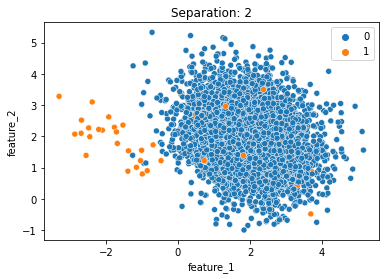

0    4950
1      50
dtype: int64


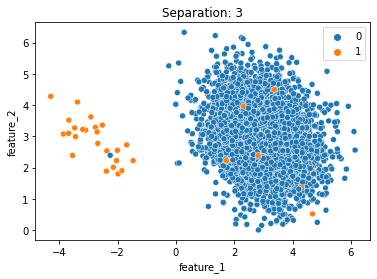

In [21]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [2, 3]:
    X, y = make_data(sep)
    synthetic_datasets.append({'data': np.array(X), 'target': np.array(y), 'DESCR': 'synthetic data, sep: ' + str(sep)})
    print(y.value_counts()) 
    sns.scatterplot(
        data=X, x="feature_1", y="feature_2", hue=y
    )
    plt.title('Separation: {}'.format(sep))
    plt.show()

## Real world data set

In [22]:
# Abalone dataset, and thyroid dataset 
from imblearn.datasets import fetch_datasets

# these datasets are baked into imbalanced-learn
dataset_list = [
    'thyroid_sick',
    'abalone_19'
]

In [23]:
# print class imbalance of each dataset
from collections import Counter
from sklearn.preprocessing import LabelEncoder

all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data['target'] = le.fit_transform(data['target'])
    all_datasets.append(data)

for item in all_datasets:
  print(Counter(item['target']))


Counter({0: 4950, 1: 50})
Counter({0: 4950, 1: 50})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [24]:
# function to train random forests and evaluate the performance
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

scaler = MinMaxScaler()

def run_model(classifier, X_train, y_train, undersampler=None):
    model = Pipeline(steps=[('minMaxScaling', scaler), ('under', undersampler), ('model', classifier)])
    
    folds = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=-1)
    print("model: ", type(classifier).__name__, " | cv_results:", mean(cv_results))
    return mean(cv_results)

In [25]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

oversampler_map = {
    'Nosampling': None,
    
    'RandomOverSampler': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),
    
    'SMOTE': SMOTE(random_state=0),

    'ADASYN': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4),

    'Borderline-SMOTE': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),
}

In [26]:
# now we train several models, with the different OverSampling techniques and
# with cross-validation for each dataset

# save results
pr_mean_dict_lr = {}
pr_mean_dict_xgb = {}

for data in all_datasets:
    pr_mean_dict_lr[data['DESCR']] = {} 
    pr_mean_dict_xgb[data['DESCR']] = {}

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data['data'],  
        data['target'], 
        test_size=0.3,
        random_state=0,
    )
    
    # train model on data without re-sampling
    # with cross-validation
    for oversampler in oversampler_map.keys():
        print(oversampler, ' | Dataset description: ', data['DESCR'])
        # set up the classifier
        lr = LogisticRegression(random_state=0, max_iter=2000)
        aps_mean_lr = run_model(lr, X_train, y_train, oversampler_map[oversampler])
        pr_mean_dict_lr[data['DESCR']][oversampler] = aps_mean_lr

        xgb = XGBClassifier()
        aps_mean_xgb = run_model(xgb, X_train, y_train, oversampler_map[oversampler])
        pr_mean_dict_xgb[data['DESCR']][oversampler] = aps_mean_xgb

        print()

Nosampling  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.766301285985194
model:  XGBClassifier  | cv_results: 0.7066453049930062

RandomOverSampler  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7901317499018649
model:  XGBClassifier  | cv_results: 0.7079333980196049

SMOTE  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7832515770734162
model:  XGBClassifier  | cv_results: 0.7066865977785517

ADASYN  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7827486689555656
model:  XGBClassifier  | cv_results: 0.6987934213508926

Borderline-SMOTE  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.776416878141016
model:  XGBClassifier  | cv_results: 0.714453857126271

Nosampling  | Dataset description:  synthetic data, sep: 3
model:  LogisticRegression  | cv_results: 0.76636541938

In [27]:
from IPython.display import display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("\033[1m Logistic Regression, Mean AUC")
df_lr = pd.DataFrame(pr_mean_dict_lr).T
display(df_lr)
print('\n')


print("\033[1m XGBoost Classifier, Mean AUC")
df_xgb = pd.DataFrame(pr_mean_dict_xgb).T
display(df_xgb)


 Logistic Regression, Mean AUC


,Nosampling,RandomOverSampler,SMOTE,ADASYN,Borderline-SMOTE
"synthetic data, sep: 2",0.766301,0.790132,0.783252,0.782749,0.776417
"synthetic data, sep: 3",0.766365,0.788082,0.780209,0.772705,0.766365
thyroid_sick,0.920277,0.948103,0.945224,0.947680,0.939729
abalone_19,0.672626,0.841296,0.831960,0.831558,0.760172




 XGBoost Classifier, Mean AUC


,Nosampling,RandomOverSampler,SMOTE,ADASYN,Borderline-SMOTE
"synthetic data, sep: 2",0.706645,0.707933,0.706687,0.698793,0.714454
"synthetic data, sep: 3",0.726651,0.743348,0.753101,0.746447,0.726651
thyroid_sick,0.994659,0.994814,0.995118,0.994188,0.995309
abalone_19,0.684854,0.639855,0.686451,0.688517,0.638537


Points to note:
1. Please note that the models used here are not tuned with the best hyperparameters. 
Tuning XGBoost parameters would likely make it better than logistic regression here (for example, try with hyperparameters of {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2})
2. There is not much difference in the performance of different over-sampling techniques.
3. Barring a few cases, usually, oversampling methods have performed better than no sampling at all 
4. As observed above, as the separation between classes increases(separation 2 vs. separation 3), oversampling techniques tend to show bigger performance gains.

                     lr   xgb
Nosampling         0.77  0.71
RandomOverSampler  0.79  0.71
SMOTE              0.78  0.71
ADASYN             0.78  0.70
Borderline-SMOTE   0.78  0.71


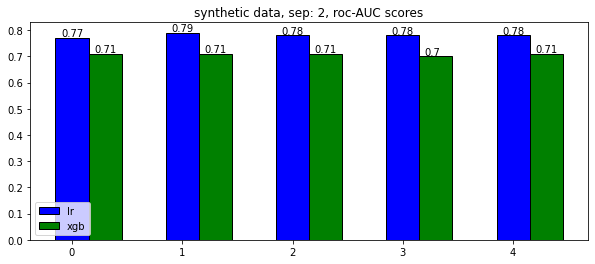

----------------------------------------------------------------

                     lr   xgb
Nosampling         0.77  0.73
RandomOverSampler  0.79  0.74
SMOTE              0.78  0.75
ADASYN             0.77  0.75
Borderline-SMOTE   0.77  0.73


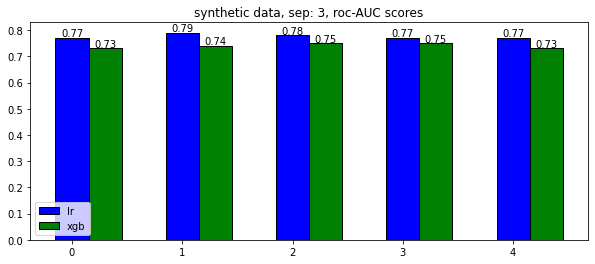

----------------------------------------------------------------

                     lr   xgb
Nosampling         0.92  0.99
RandomOverSampler  0.95  0.99
SMOTE              0.95  1.00
ADASYN             0.95  0.99
Borderline-SMOTE   0.94  1.00


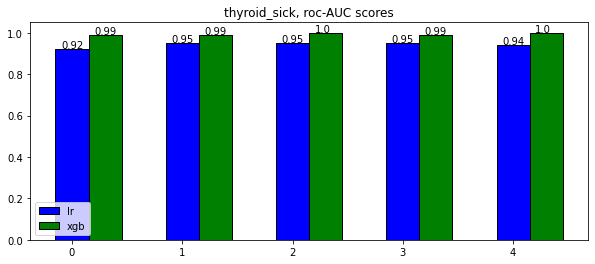

----------------------------------------------------------------

                     lr   xgb
Nosampling         0.67  0.68
RandomOverSampler  0.84  0.64
SMOTE              0.83  0.69
ADASYN             0.83  0.69
Borderline-SMOTE   0.76  0.64


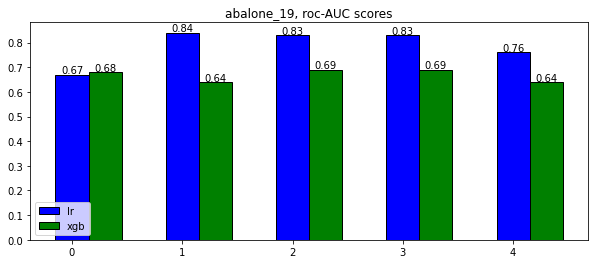

----------------------------------------------------------------



In [45]:
# Now we plot the performance of the model in the 
for (i, dataset) in enumerate(all_datasets):
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset['DESCR']]).round(2)
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset['DESCR']]).round(2)
    df = pd.DataFrame([pr_mean_s_lr, pr_mean_s_xgb], index=['lr' ,'xgb']).T
    print(df)

    r = np.arange(5)
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(r, df['lr'], color = 'b',
                   width = .3, edgecolor = 'black',
                   label='lr')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.05, yval + .005, yval)
    
    bars = plt.bar(r+0.3, df['xgb'], color = 'g',
                   width = .3, edgecolor = 'black',
                   label='xgb')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.05, yval + .005, yval)
    plt.legend(loc="lower left")
    plt.title("%s, roc-AUC scores"%(all_datasets[i]["DESCR"]))
    plt.show()
    print("----------------------------------------------------------------\n")